Clustering Mental Health in Tech Survey:

Intent
-------
The purpose of this notebook is to research and apply best practices for clustering discrete data. (from surveys) I will be using the data obtained from a large scale survey of the tech workforce, asking questions about mental health in the workplace. Upon completion I will have practiced encoding discrete and categorical data, as well as analysis and visualization. Most importantly, I will apply the appropriate clustering algorithm, tune hyperparameters, and measure the results. I will conclude with a brief decision tree analysis that show the key characteristic of each cluster.

Description of the Data
"This dataset contains the following data:

Timestamp

Age

Gender

Country

state: If you live in the United States, which state or territory do you live in?

self_employed: Are you self-employed?

family_history: Do you have a family history of mental illness?

treatment: Have you sought treatment for a mental health condition?

work_interfere: If you have a mental health condition, do you feel that it interferes with your work?

no_employees: How many employees does your company or organization have?

remote_work: Do you work remotely (outside of an office) at least 50% of the time?

tech_company: Is your employer primarily a tech company/organization?

benefits: Does your employer provide mental health benefits?

care_options: Do you know the options for mental health care your employer provides?

wellness_program: Has your employer ever discussed mental health as part of an employee wellness program?

seek_help: Does your employer provide resources to learn more about mental health issues and how to seek help?

anonymity: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?

leave: How easy is it for you to take medical leave for a mental health condition?

mental_health_consequence: Do you think that discussing a mental health issue with your employer would have negative consequences?

phys_health_consequence: Do you think that discussing a physical health issue with your employer would have negative consequences?

coworkers: Would you be willing to discuss a mental health issue with your coworkers?

supervisor: Would you be willing to discuss a mental health issue with your direct supervisor(s)?

mental_health_interview: Would you bring up a mental health issue with a potential employer in an interview?

phys_health_interview: Would you bring up a physical health issue with a potential employer in an interview?

mental_vs_physical: Do you feel that your employer takes mental health as seriously as physical health?

obs_consequence: Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?

comments: Any additional notes or comments"

Import the Dataset and Preview


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as  sns
import re
%matplotlib inline
plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Colab Notebooks/Advance project/mental health survey/


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Advance project/mental health survey


In [18]:
survey = pd.read_csv('survey.csv')
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


Preprocessing

--------------------------


Review of Changes to Come in EDA Section


Threw out responses that could not be easily be categorized into "Male" and "Female". (No political commentary here, just avoiding outlier issues.)

Threw out responses with ages such that 15 < age < 55. (Same logic.)

----------------------------
Removing Superfluous Data


As they will not be useful to our clustering algorithm, we remove the Timestamp and comments columns.

 Later on, we will also have to remove some of our demographic info so our clustering algorithm can focus solely on the question content of the survey.

In [19]:
survey = survey.drop(["Timestamp", "comments", "state"], axis =1)

Check for Empty Values


We have 1209 responses left in our data. The columns with the most non-responses are Work_interfere and self_employed. (with 258 and 18 non-responses, respectively) In the case of "work_interfere" we will have to throw out the column, imputing the values would be to detrimental as we are missing nearly 30% of the data. For "self_employed" we fill in the missing answers with the most frequently seen response.

In [20]:
from sklearn.impute import SimpleImputer

survey = survey.drop(["work_interfere"], axis =1)

Label Encoding


Since KMeans and other machine learning algorithms can only understand numerical data, we will have to convert the text answers of the survey to disctete numbers. For example yes/no becomes 1/0. To do this well takes a lot of thought, unfortunately a major limitation of the data is the inclusion of the "don't know" response in some of the survey questions. The ambiguity implicit in this answer will surely limit the effectiveness of a clustering algorithm, however, the purpose of this exerise is practice. So we push forward.

In [21]:
encoders = dict()
enc_no_employees = {'1-5':0, '6-25':1, '26-100':2, '100-500':3, '500-1000':4, 'More than 1000':5}
surv_no_employees = survey.no_employees.apply(lambda row: enc_no_employees[row])

enc_leave = {'Somewhat easy':3, "Don't know":2, 'Somewhat difficult':1,
       'Very difficult':0, 'Very easy':4}
surv_leave = survey.leave.apply(lambda row: enc_leave[row])

for x in range(2,23):
    encoders['le'+str(x-2)]= LabelEncoder()
    survey.iloc[:,x] = encoders['le'+str(x-2)].fit_transform(survey.iloc[:,x].astype(str))
survey['leave'] = surv_leave
survey['no_employees'] = surv_no_employees
survey.head()

,Age,Gender,Country,self_employed,family_history,treatment,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,45,2,0,1,1,0,1,2,...,2,3,1,1,1,2,1,0,2,0
1,44,M,45,2,0,0,5,0,0,0,...,0,2,0,1,0,0,1,1,0,0
2,32,Male,7,2,0,0,1,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,31,Male,44,2,1,1,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,31,Male,45,2,0,0,3,1,1,2,...,0,2,1,1,1,2,2,2,0,0


Now that we have encoded our data, we can finish the section above by imputing the "self_employed" column. (We never did that)

In [22]:
labels = survey.columns
imp = SimpleImputer(strategy = 'most_frequent')
survey = pd.DataFrame(imp.fit_transform(survey), columns = labels)

Beautiful. We have no missing values. Data that is encoded numerically in a way that more contextually similar answers are closer together in euclidean space. We should be good to go for clustering.

EDA: Demographic Info
---
Gender of Respondents


We are going to need to do a little bit of prep here as our surveys Gender column was collected as text. As a result, we have issues with capitilization, spelling errors, and abbreviations. We will remove all of the respondents that are not male/female as I cannot easily categorize an "Other" category.

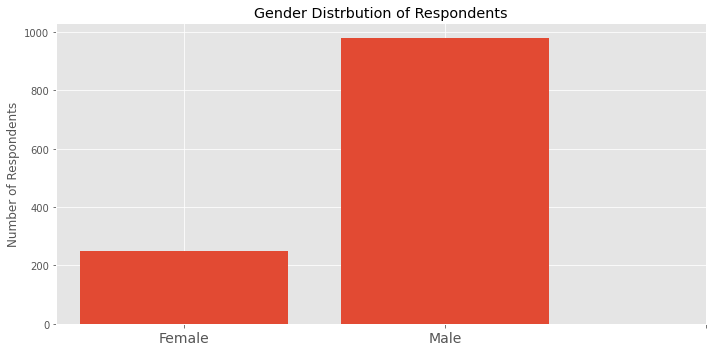

In [23]:
def encode(text):
    text = text.lower()
    if text in ['male', 'm', 'mail', 'make','man', 'malr','mal', 'maile',]:
        text = 1
        return text
    elif text in ['f', 'female', 'femake', 'woman']:
        text = 0
        return text
    elif 'female' in text:
        text = 0
        return text
    else:
        text = 2
        return text

survey.Gender = survey.Gender.apply(encode)

survey = survey[survey.Gender !=2]
plt.figure(figsize =(10,5))
plt.bar(survey.Gender.value_counts().index, survey.Gender.value_counts())
xticks = plt.gca()
plt.xticks([0,1,2], ['Female','Male'])
plt.gca().set_xticklabels(['Female', 'Male'], fontsize = 14)
plt.title('Gender Distrbution of Respondents')
plt.ylabel('Number of Respondents')
plt.tight_layout()
plt.show()

Age Distribution of Respondents
--------
We have removed responses with age less than 15 and greater than 55. Removal of outliers will make clustering easier as we continue. The average age of respondents is 35.

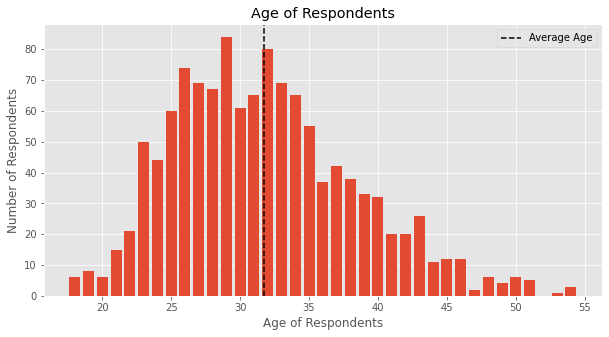

In [24]:
survey = survey[survey.Age>15]
survey = survey[survey.Age<55]

plt.figure(figsize =(10,5))
survey.Age.value_counts()
plt.bar(survey.Age.value_counts().index, survey.Age.value_counts())
plt.title('Age of Respondents')
plt.ylabel('Number of Respondents')
plt.xlabel('Age of Respondents')
av_age = np.mean(survey.Age)
plt.axvline(av_age,
           color = 'black',
           linestyle = '--'
           , label='Average Age')
plt.legend()
plt.show()

Nationality of Respondents
-----
Around 60% or respondents came from the US, and another 14% comes from the UK.

In [28]:
survey.Country.value_counts()

45    719
44    176
7      69
17     43
21     27
28     27
0      21
15     13
20     10
29      8
33      7
23      7
41      7
42      7
3       6
5       6
22      5
39      5
37      4
6       4
26      3
1       3
14      3
13      2
18      2
9       2
36      2
11      2
34      2
16      1
27      1
8       1
43      1
12      1
31      1
25      1
30      1
24      1
19      1
4       1
46      1
40      1
35      1
10      1
38      1
32      1
Name: Country, dtype: int64

EDA: Conclusion


As we continue on to the actual clustering of the data, we are going to remove the Country, Gender and Age column from our data. The reason behind this decision, is that categorical variables like Country, add to much complexity to the model. I ight be able to come up with smart features through some smart feature engineering, but the effort would outweigh the gain, and this is merely an exersice.

In [29]:
survey = survey.drop(["Age", "Gender",], axis = 1)
survey = survey.drop(["Country"], axis =1)

Clustering without PCA
---------

In this section I go about the clustering process with the KMeans, and Agglomerative Clustering algorithms. In the next section we will reduce the dimension of the feature space, for now we are imputing the entirety of our data in each algorithm and looking for the right number of clusters.

---------------------


K-Means and Clustering Metrics


Inertia Plot

Below is a plot of the inertia decrese as we increase the number of clusters. Remember we want our inertia to be LOW. A low inertia means our clusters are very tightly packed, like peas in a pod. There is no hard elbow, so we pick a good number of clusters to be 5.(This is based on the diminishing decrease of inertia.)

In [31]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN #For clustering
from matplotlib import cm
from sklearn.metrics import silhouette_samples, silhouette_score


def inertia_plot( clust, X, start = 2, stop = 10):
    #A simple inertia plotter to decide K in KMeans
    inertia = []
    for x in range(start,stop):
        km = clust(n_clusters = x)
        labels = km.fit_predict(X)
        inertia.append(km.inertia_)
    plt.figure(figsize = (10,6))
    plt.plot(range(start,stop), inertia, marker = 'o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia Decrease with K')
    plt.xticks(list(range(start, stop)))
    plt.show()

def silh_samp_cluster(clust,  X, start=2, stop=5, metric = 'euclidean'):
    # Taken from sebastian Raschkas book Python Machine Learning second edition
    for x in range(start, stop):
        km = clust(n_clusters = x)
        y_km = km.fit_predict(X)
        cluster_labels = np.unique(y_km)
        n_clusters = cluster_labels.shape[0]
        silhouette_vals = silhouette_samples(X, y_km, metric = metric)
        y_ax_lower, y_ax_upper =0,0
        yticks = []
        for i, c in enumerate(cluster_labels):
            c_silhouette_vals = silhouette_vals[y_km == c]
            c_silhouette_vals.sort()
            y_ax_upper += len(c_silhouette_vals)
            color = cm.jet(float(i)/n_clusters)
            plt.barh(range(y_ax_lower, y_ax_upper),
                    c_silhouette_vals,
                    height=1.0,
                    edgecolor='none',
                    color = color)
            yticks.append((y_ax_lower + y_ax_upper)/2.)
            y_ax_lower+= len(c_silhouette_vals)

        silhouette_avg = np.mean(silhouette_vals)
        plt.axvline(silhouette_avg,
                   color = 'red',
                   linestyle = "--")
        plt.yticks(yticks, cluster_labels+1)
        plt.ylabel("cluster")
        plt.xlabel('Silhouette Coefficient')
        plt.title('Silhouette for ' + str(x) + " Clusters")
        plt.show()

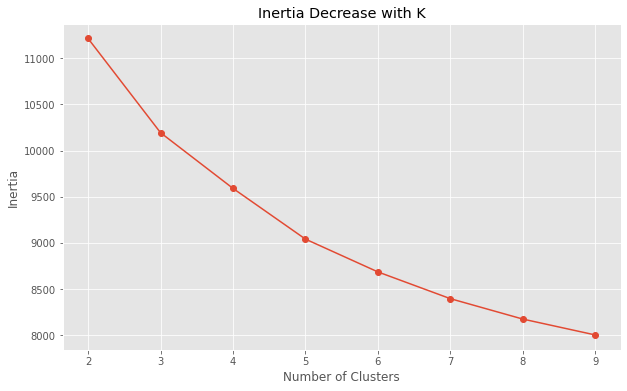

In [32]:
inertia_plot(KMeans, survey)

Silhouette Scores


Next we have silhouette scores for different numbers of clusters. A score of -1 means poor clustering, 0 means cluster overrlap, and 1 means good clusterning. (good clustering is tightly packed clusters that are far away from each other.)

In [33]:
for x in range(2,8):
    ag = KMeans(n_clusters = x, )
    label = ag.fit_predict(survey)
    print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey, label))


Silhouette-Score for 2 Clusters:  0.1901790243780608
Silhouette-Score for 3 Clusters:  0.14177130361976967
Silhouette-Score for 4 Clusters:  0.12017640675951181
Silhouette-Score for 5 Clusters:  0.11309235614707622
Silhouette-Score for 6 Clusters:  0.11561250173651885
Silhouette-Score for 7 Clusters:  0.1140180084429152


Silhouette Plots


Latly we have silhouette plots which are the silhouette scores of every sample within each cluster. Note that imbalanced clusters lead to wider bars. Samples with higher spectrall coefficient are close to their cluster mates, and far from their neighbors in other clusters

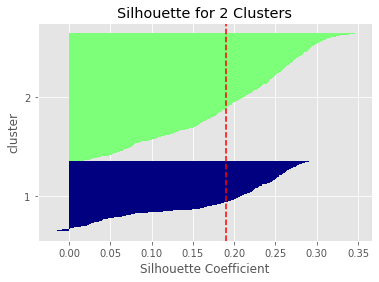

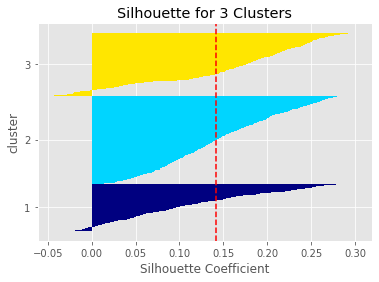

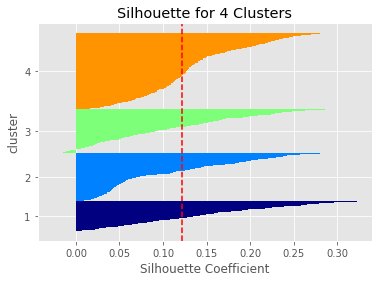

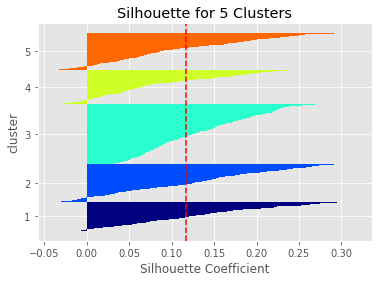

In [35]:
silh_samp_cluster(KMeans, survey, stop =6)

Conclusion


Not great. We have a high average inertia, low silhouette scrores, and a high variance in the silhouette plots.Lets try agglomerative Clustering

Agglomerative Clustering

Silhouette Scores

In [37]:
for x in range(2,8):
    ag = AgglomerativeClustering(n_clusters = x, )
    label = ag.fit_predict(survey)
    print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey, label))


Silhouette-Score for 2 Clusters:  0.1965709194292001
Silhouette-Score for 3 Clusters:  0.11195933280363203
Silhouette-Score for 4 Clusters:  0.09979111096256836
Silhouette-Score for 5 Clusters:  0.08727975194310092
Silhouette-Score for 6 Clusters:  0.08760098945117002
Silhouette-Score for 7 Clusters:  0.08980342970987766


Silhouette Plots

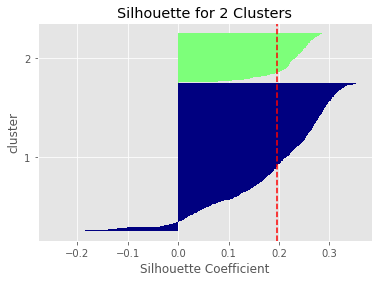

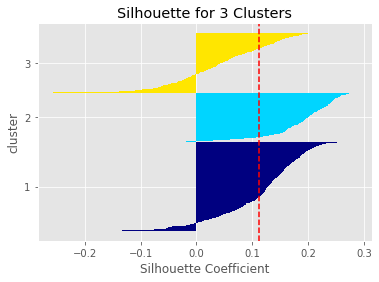

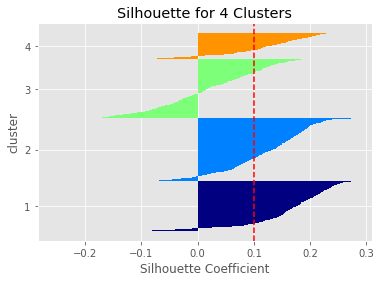

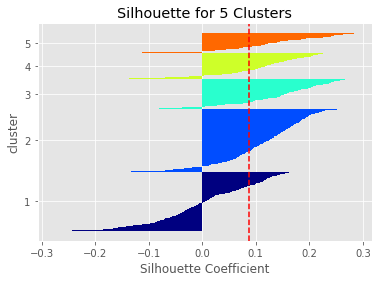

In [38]:
silh_samp_cluster(AgglomerativeClustering, survey, stop =6)

Clustering with PCA
-------


KMeans with PCA


Silhouette Scores and Inertias

Below we see much improved silhouette scores, and lower average inertia following a dimension reduction with Pricipal Component Analysis. Based on the data below, i would say that 2 components, and 4-6 clusters would be the best bet.

In [39]:
from sklearn.decomposition import PCA
for y in range(2,6):
    print("PCA with # of components: ", y)
    pca = PCA(n_components =y)
    survey_p = pca.fit_transform(survey)
    for x in range(2, 9):
        ag = KMeans(n_clusters = x, )
        label = ag.fit_predict(survey_p)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey_p, label) , '       Inertia: ',ag.inertia_)
    print()

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.4347889505690773        Inertia:  3061.144328631787
Silhouette-Score for 3 Clusters:  0.40862042430995366        Inertia:  2057.4672486746235
Silhouette-Score for 4 Clusters:  0.38772144119938956        Inertia:  1542.8228860309227
Silhouette-Score for 5 Clusters:  0.38572405907210877        Inertia:  1177.7450963304475
Silhouette-Score for 6 Clusters:  0.39169347078999606        Inertia:  954.070045224269
Silhouette-Score for 7 Clusters:  0.3837523809774468        Inertia:  824.654180789016
Silhouette-Score for 8 Clusters:  0.37810510295307165        Inertia:  721.5612334029059

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.3480687584985226        Inertia:  4575.29594359843
Silhouette-Score for 3 Clusters:  0.3057297433658143        Inertia:  3570.804561779858
Silhouette-Score for 4 Clusters:  0.28725561551386497        Inertia:  2986.6897790686617
Silhouette-Score for 5 Clusters:  0.28861196682591195 

Visualizing in 2 Dimensions
----

Lets visualize a scatterplot with 2 principal components, and 5 clusters determined with the KMeans Algorithm

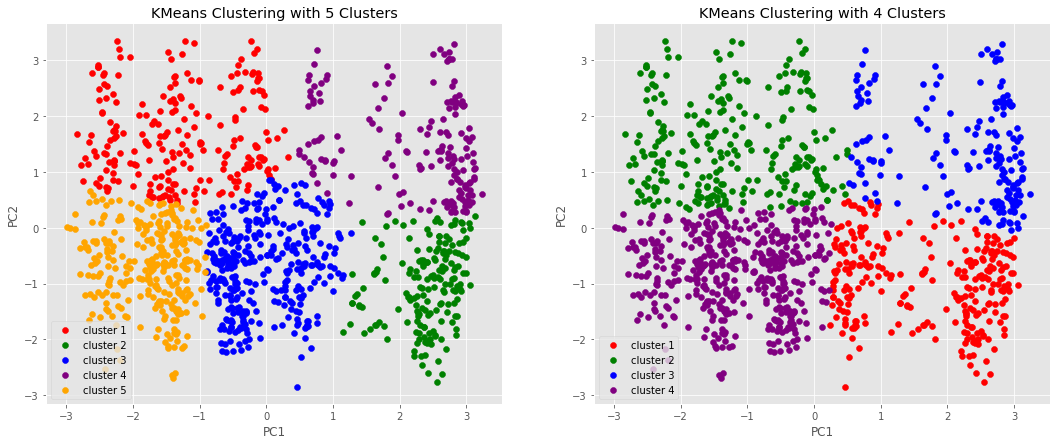

In [40]:
survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(KMeans(n_clusters = 5,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('KMeans Clustering with 5 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(KMeans(n_clusters = 4,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.legend()
plt.title('KMeans Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Visualizing in 3 Dimensions


Now with 3 Prinipal Components

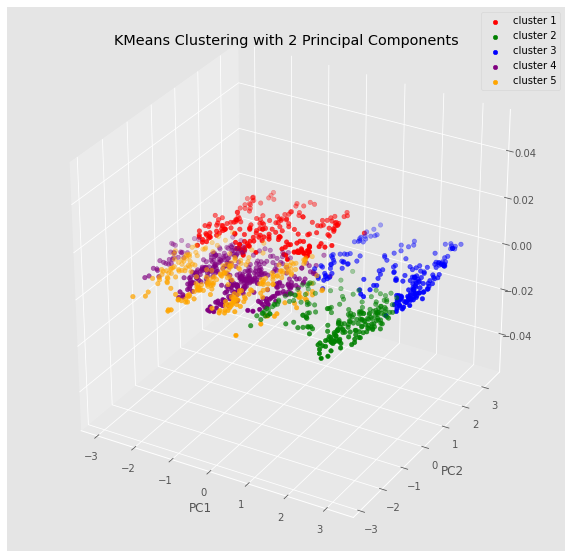

In [41]:
from mpl_toolkits.mplot3d import Axes3D

survey_p3 = pd.DataFrame(PCA(n_components = 3).fit_transform(survey))
preds = pd.Series(KMeans(n_clusters = 5,).fit_predict(survey_p3))
survey_p3 = pd.concat([survey_p3, preds], axis =1)
survey_p3.columns = [0,1,2, 'target']

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange']
ax.scatter(survey_p3[survey_p3['target']==0].iloc[:,0], survey_p3[survey_p3.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
ax.scatter(survey_p3[survey_p3['target']==1].iloc[:,0], survey_p3[survey_p3.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
ax.scatter(survey_p3[survey_p3['target']==2].iloc[:,0], survey_p3[survey_p3.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
ax.scatter(survey_p3[survey_p3['target']==3].iloc[:,0], survey_p3[survey_p3.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
ax.scatter(survey_p3[survey_p3['target']==4].iloc[:,0], survey_p3[survey_p3.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('KMeans Clustering with 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Conclusion
------

Based on the above analysis, we made some serious gains with applying the PCA, but there are distinct patterns in the 2 dimensional data that I would like to capture. Next we try the same process with Agglomerative Clustering.

Agglomerative Clustering with PCA
-------


Silhouette Scores


Ag has no inertia metric.

In [42]:
for y in range(2,6):
    print("PCA with # of components: ", y)
    pca = PCA(n_components =y)
    survey_p = pca.fit_transform(survey)
    for x in range(2, 9):
        ag = AgglomerativeClustering(n_clusters = x, )
        label = ag.fit_predict(survey_p)
        print('Silhouette-Score for', x,  'Clusters: ', silhouette_score(survey_p, label))
    print()

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.45027946582010553
Silhouette-Score for 3 Clusters:  0.38309063275349003
Silhouette-Score for 4 Clusters:  0.3609711750152028
Silhouette-Score for 5 Clusters:  0.32205479899161804
Silhouette-Score for 6 Clusters:  0.32318572843949633
Silhouette-Score for 7 Clusters:  0.31783249172385625
Silhouette-Score for 8 Clusters:  0.31811418844849515

PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.35385072071796836
Silhouette-Score for 3 Clusters:  0.2492831110799102
Silhouette-Score for 4 Clusters:  0.2385292044919546
Silhouette-Score for 5 Clusters:  0.23795452118798177
Silhouette-Score for 6 Clusters:  0.24616962571717244
Silhouette-Score for 7 Clusters:  0.2340759723781088
Silhouette-Score for 8 Clusters:  0.22755799125596887

PCA with # of components:  4
Silhouette-Score for 2 Clusters:  0.3154353968101528
Silhouette-Score for 3 Clusters:  0.2273236271471793
Silhouette-Score for 4 Clusters:  0.2112504080398115


Visualizing in 2 Dimensions

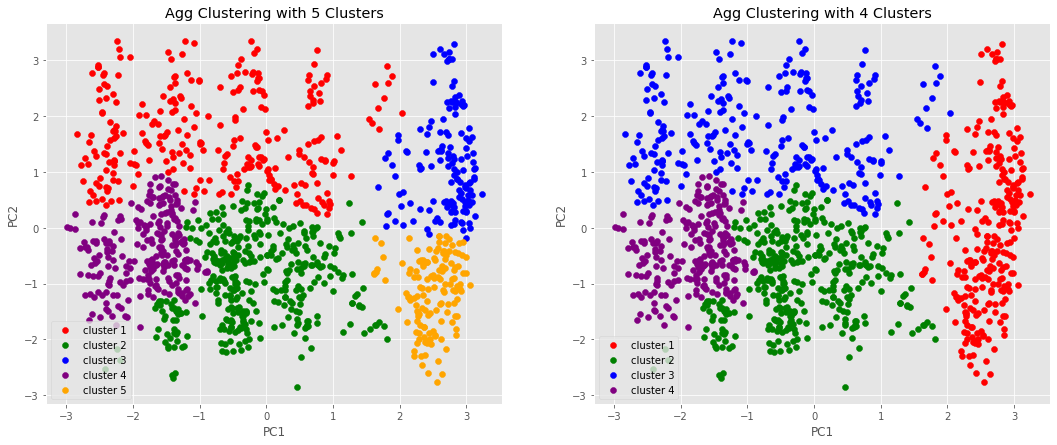

In [43]:
survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(AgglomerativeClustering(n_clusters = 5,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('Agg Clustering with 5 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(AgglomerativeClustering(n_clusters = 4,).fit_predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.legend()
plt.title('Agg Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Visualizing in 3 Dimensions

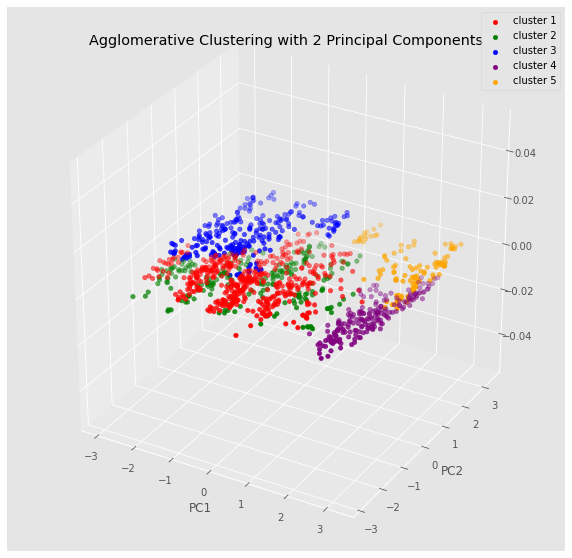

In [44]:
survey_p3 = pd.DataFrame(PCA(n_components = 3).fit_transform(survey))
preds = pd.Series(AgglomerativeClustering(n_clusters = 5,).fit_predict(survey_p3))
survey_p3 = pd.concat([survey_p3, preds], axis =1)
survey_p3.columns = [0,1,2, 'target']

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange']
ax.scatter(survey_p3[survey_p3['target']==0].iloc[:,0], survey_p3[survey_p3.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
ax.scatter(survey_p3[survey_p3['target']==1].iloc[:,0], survey_p3[survey_p3.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
ax.scatter(survey_p3[survey_p3['target']==2].iloc[:,0], survey_p3[survey_p3.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
ax.scatter(survey_p3[survey_p3['target']==3].iloc[:,0], survey_p3[survey_p3.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
ax.scatter(survey_p3[survey_p3['target']==4].iloc[:,0], survey_p3[survey_p3.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('Agglomerative Clustering with 2 Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Conclusion
------

Good job, but there is one more thing I want to try, a Gaussian Mixture Model.

Gaussian Mixture with PCA
----

Visualizing in 2 dimensions

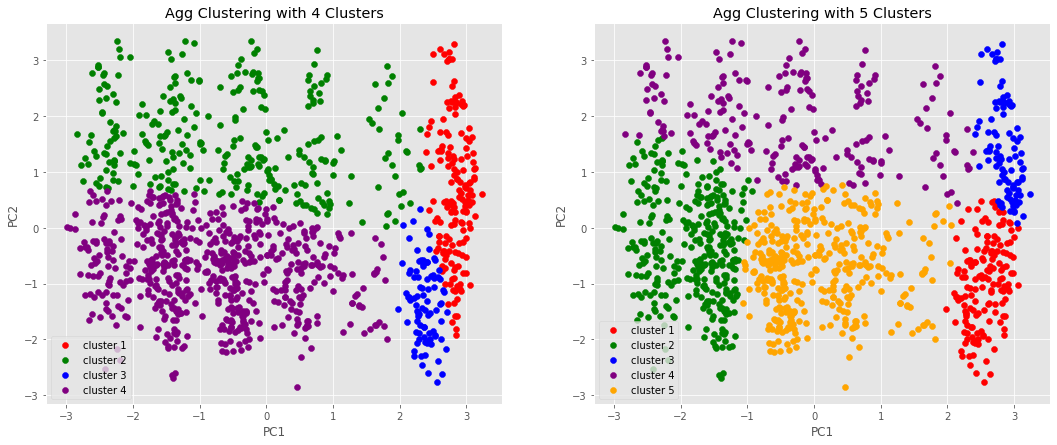

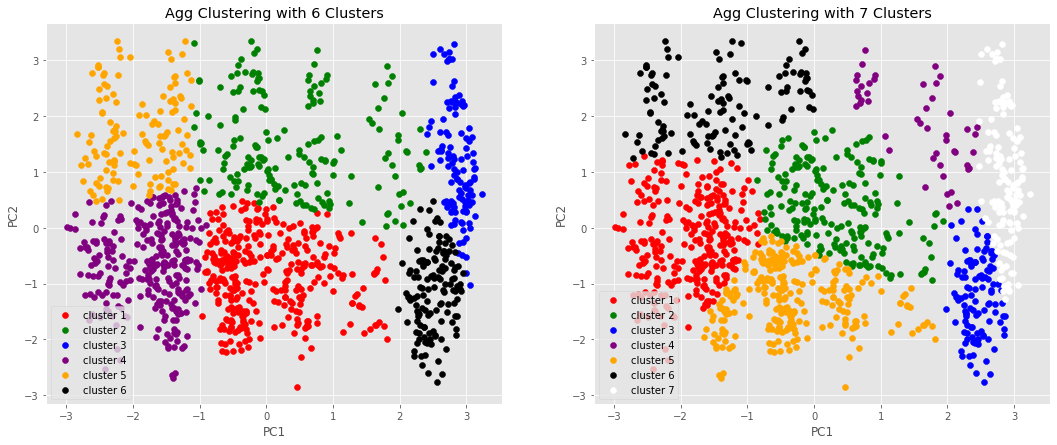

In [45]:
from sklearn.mixture import GaussianMixture

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 5,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange']
plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('Agg Clustering with 5 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 4,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.legend()
plt.title('Agg Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 6,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'white']
plt.subplot(121)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.scatter(survey_p[survey_p['target']==5].iloc[:,0], survey_p[survey_p.target==5].iloc[:,1], c = colors[5], label = 'cluster 6')

plt.legend()
plt.title('Agg Clustering with 6 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

survey_p = pd.DataFrame(PCA(n_components = 2).fit_transform(survey))
preds = pd.Series(GaussianMixture(n_components = 7,).fit(survey_p).predict(survey_p))
survey_p = pd.concat([survey_p, preds], axis =1)
survey_p.columns = [0,1,'target']

plt.subplot(122)
plt.scatter(survey_p[survey_p['target']==0].iloc[:,0], survey_p[survey_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(survey_p[survey_p['target']==1].iloc[:,0], survey_p[survey_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(survey_p[survey_p['target']==2].iloc[:,0], survey_p[survey_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(survey_p[survey_p['target']==3].iloc[:,0], survey_p[survey_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(survey_p[survey_p['target']==4].iloc[:,0], survey_p[survey_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.scatter(survey_p[survey_p['target']==5].iloc[:,0], survey_p[survey_p.target==5].iloc[:,1], c = colors[5], label = 'cluster 6')
plt.scatter(survey_p[survey_p['target']==6].iloc[:,0], survey_p[survey_p.target==6].iloc[:,1], c = colors[6], label = 'cluster 7')

plt.legend()
plt.title('Agg Clustering with 7 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
plt.show()

Conclusion
---------


In conclusion, we practiced our data preprocessing. We looked at different metrics for evaluating how good the clustering was like silhouette scores and inertia. Then we found that the best clustering models were generally once we reduced the data down to two dimenstions and searched for 4-5 clusters in the data.

